- Première étape afficher la corrélation entre le temps de résolution et la priority ainsi que le moyen de contact
- Retirer toutes les lignes dont l'incident n'est pas résolu ou clos
- Créer une nouvelle dataframe avec seulement les valeurs qui nous intéressent pour faire la régréssion

In [0]:
# Lié son drive afin d'avoir accès aux docs du drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Dépendances, à savoir que toutes ne sont pas utiles, il faudra que je trie à la fin
# oeil --> outils mathématique pour trouver les correlations, Boruta
import pandas as pd
import numpy as np
import datetime as dt
from   random import randint
import math
import re
import scipy
import seaborn as sns

from pylab import *
import matplotlib.pyplot as plt
import matplotlib

from sklearn import preprocessing

In [0]:
def time_to_resolve(dataframe):
  delta = []
  for index, row in dataframe.iterrows():
    delta.append(dataframe.resolved_at[index] - dataframe.opened_at[index])
  
  new_dataframe = pd.DataFrame(delta, columns = {'time_to_resolve'})
  return new_dataframe

In [0]:
def improvement_of_the_df(dataframe):
  for index, row in dataframe.iterrows():
    dataframe.priority[index] = dataframe.priority[index][0]

On peut drop :
 - cmdb_ci --> 141 267 / 141 712 valeurs NA

In [0]:
df_incident_log_event = pd.read_csv("drive/My Drive/incident_event_log.csv", sep=",", encoding="ISO-8859-1", decimal=",")
df_incident_log_event

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,Updated by 746,29/2/2016 04:57,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,INC0120835,Closed,False,1,0,4,True,Caller 116,Opened by 12,16/2/2017 09:09,?,?,Updated by 27,16/2/2017 09:53,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,16/2/2017 09:53,16/2/2017 09:53
141708,INC0121064,Active,True,0,0,0,True,Caller 116,Opened by 12,16/2/2017 14:17,?,?,Updated by 908,16/2/2017 14:17,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify,?,?,?,?,code 6,Resolved by 9,16/2/2017 16:38,16/2/2017 16:38
141709,INC0121064,Active,True,1,0,1,True,Caller 116,Opened by 12,16/2/2017 14:17,?,?,Updated by 60,16/2/2017 15:20,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 31,?,False,False,Do Not Notify,?,?,?,?,code 6,Resolved by 9,16/2/2017 16:38,16/2/2017 16:38
141710,INC0121064,Resolved,True,1,0,2,True,Caller 116,Opened by 12,16/2/2017 14:17,?,?,Updated by 27,16/2/2017 16:38,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 6,Resolved by 9,16/2/2017 16:38,16/2/2017 16:38


In [0]:
df_incident_log_event.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

In [0]:
df_incident_log_event['incident_state'].value_counts()

Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: incident_state, dtype: int64

In [0]:
df_incident_log_event.dtypes

number                     object
incident_state             object
active                       bool
reassignment_count          int64
reopen_count                int64
sys_mod_count               int64
made_sla                     bool
caller_id                  object
opened_by                  object
opened_at                  object
sys_created_by             object
sys_created_at             object
sys_updated_by             object
sys_updated_at             object
contact_type               object
location                   object
category                   object
subcategory                object
u_symptom                  object
cmdb_ci                    object
impact                     object
urgency                    object
priority                   object
assignment_group           object
assigned_to                object
knowledge                    bool
u_priority_confirmation      bool
notify                     object
problem_id                 object
rfc           

In [0]:
df_incident_log_event.describe()

,reassignment_count,reopen_count,sys_mod_count
count,141712.000000,141712.000000,141712.000000
mean,1.104197,0.021918,5.080946
std,1.734673,0.207302,7.680652
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,0.000000,3.000000
75%,1.000000,0.000000,6.000000
max,27.000000,8.000000,129.000000


In [0]:
df_incident_log_event["contact_type"].unique()

array(['Phone', 'Email', 'Self service', 'Direct opening', 'IVR'],
      dtype=object)

In [0]:
df_calcul = df_incident_log_event.copy()

In [0]:
# Drop on the column incident state
df_calcul = df_calcul.drop(df_calcul[df_calcul["incident_state"] == "Active" ].index)
df_calcul = df_calcul.drop(df_calcul[df_calcul["incident_state"] == "New" ].index)
df_calcul = df_calcul.drop(df_calcul[df_calcul["incident_state"] == "Awaiting Vendor" ].index)
df_calcul = df_calcul.drop(df_calcul[df_calcul["incident_state"] == "Awaiting Evidence" ].index)
df_calcul = df_calcul.drop(df_calcul[df_calcul["incident_state"] == "-100" ].index)
df_calcul = df_calcul.drop(df_calcul[df_calcul["incident_state"] == "Awaiting Problem" ].index)
df_calcul = df_calcul.drop(df_calcul[df_calcul["incident_state"] == "Awaiting User Info" ].index)

# Drop on the column resolved_at, closed_at and opened_at
df_calcul = df_calcul.drop(df_calcul[df_calcul["opened_at"] == "?" ].index)
df_calcul = df_calcul.drop(df_calcul[df_calcul["resolved_at"] == "?" ].index)
df_calcul = df_calcul.drop(df_calcul[df_calcul["closed_at"] == "?" ].index)

# Rewriting of the columns to be more easy to compute on it
improvement_of_the_df(df_calcul)

df_calcul["resolved_at"] = pd.to_datetime(df_calcul.resolved_at, format="%d/%m/%Y %H:%M")
df_calcul["opened_at"]   = pd.to_datetime(df_calcul.opened_at, format="%d/%m/%Y %H:%M")
df_calcul["closed_at"]   = pd.to_datetime(df_calcul.closed_at, format="%d/%m/%Y %H:%M")
df_calcul["priority"]   = df_calcul["priority"]

le = preprocessing.LabelEncoder()
le.fit(['Phone', 'Email', 'Self service', 'Direct opening', 'IVR']) # 0 = Direct Opening | 1 = Email | 2 = IVR | 3 = Phone | 4 = Self Service
df_calcul["contact_type"] = le.transform(df_calcul["contact_type"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df_calcul

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,3,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,3,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,3,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00
11,INC0000047,Resolved,True,1,0,7,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,Created by 171,29/2/2016 04:57,Updated by 332,1/3/2016 09:52,3,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3,Group 24,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00
12,INC0000047,Closed,False,1,0,8,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,Created by 171,29/2/2016 04:57,Updated by 908,6/3/2016 10:00,3,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3,Group 24,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141695,INC0120304,Closed,False,0,0,2,True,Caller 90,Opened by 8,2017-02-15 02:02:00,?,?,Updated by 21,17/2/2017 00:50,1,Location 188,Category 52,Subcategory 177,Symptom 494,?,2 - Medium,2 - Medium,3,Group 64,Resolver 6,False,True,Do Not Notify,?,?,?,?,code 6,Resolved by 5,2017-02-17 00:47:00,2017-02-17 00:50:00
141706,INC0120835,Resolved,True,1,0,3,True,Caller 116,Opened by 12,2017-02-16 09:09:00,?,?,Updated by 27,16/2/2017 09:53,1,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,2017-02-16 09:53:00,2017-02-16 09:53:00
141707,INC0120835,Closed,False,1,0,4,True,Caller 116,Opened by 12,2017-02-16 09:09:00,?,?,Updated by 27,16/2/2017 09:53,1,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,2017-02-16 09:53:00,2017-02-16 09:53:00
141710,INC0121064,Resolved,True,1,0,2,True,Caller 116,Opened by 12,2017-02-16 14:17:00,?,?,Updated by 27,16/2/2017 16:38,1,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 6,Resolved by 9,2017-02-16 16:38:00,2017-02-16 16:38:00


In [0]:
df_calcul = df_calcul.reset_index()
df_calcul

,index,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,3,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00
1,2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,3,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00
2,3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,3,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00
3,11,INC0000047,Resolved,True,1,0,7,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,Created by 171,29/2/2016 04:57,Updated by 332,1/3/2016 09:52,3,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3,Group 24,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00
4,12,INC0000047,Closed,False,1,0,8,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,Created by 171,29/2/2016 04:57,Updated by 908,6/3/2016 10:00,3,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3,Group 24,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47612,141695,INC0120304,Closed,False,0,0,2,True,Caller 90,Opened by 8,2017-02-15 02:02:00,?,?,Updated by 21,17/2/2017 00:50,1,Location 188,Category 52,Subcategory 177,Symptom 494,?,2 - Medium,2 - Medium,3,Group 64,Resolver 6,False,True,Do Not Notify,?,?,?,?,code 6,Resolved by 5,2017-02-17 00:47:00,2017-02-17 00:50:00
47613,141706,INC0120835,Resolved,True,1,0,3,True,Caller 116,Opened by 12,2017-02-16 09:09:00,?,?,Updated by 27,16/2/2017 09:53,1,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,2017-02-16 09:53:00,2017-02-16 09:53:00
47614,141707,INC0120835,Closed,False,1,0,4,True,Caller 116,Opened by 12,2017-02-16 09:09:00,?,?,Updated by 27,16/2/2017 09:53,1,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,2017-02-16 09:53:00,2017-02-16 09:53:00
47615,141710,INC0121064,Resolved,True,1,0,2,True,Caller 116,Opened by 12,2017-02-16 14:17:00,?,?,Updated by 27,16/2/2017 16:38,1,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 6,Resolved by 9,2017-02-16 16:38:00,2017-02-16 16:38:00


In [0]:
df_calcul_test = df_calcul.join(time_to_resolve(df_calcul))
df_calcul_test

,index,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,time_to_resolve
0,1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,3,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,0 days 10:13:00
1,2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,3,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,0 days 10:13:00
2,3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,3,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,0 days 10:13:00
3,11,INC0000047,Resolved,True,1,0,7,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,Created by 171,29/2/2016 04:57,Updated by 332,1/3/2016 09:52,3,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3,Group 24,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00,1 days 05:12:00
4,12,INC0000047,Closed,False,1,0,8,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,Created by 171,29/2/2016 04:57,Updated by 908,6/3/2016 10:00,3,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3,Group 24,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00,1 days 05:12:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47612,141695,INC0120304,Closed,False,0,0,2,True,Caller 90,Opened by 8,2017-02-15 02:02:00,?,?,Updated by 21,17/2/2017 00:50,1,Location 188,Category 52,Subcategory 177,Symptom 494,?,2 - Medium,2 - Medium,3,Group 64,Resolver 6,False,True,Do Not Notify,?,?,?,?,code 6,Resolved by 5,2017-02-17 00:47:00,2017-02-17 00:50:00,1 days 22:45:00
47613,141706,INC0120835,Resolved,True,1,0,3,True,Caller 116,Opened by 12,2017-02-16 09:09:00,?,?,Updated by 27,16/2/2017 09:53,1,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,2017-02-16 09:53:00,2017-02-16 09:53:00,0 days 00:44:00
47614,141707,INC0120835,Closed,False,1,0,4,True,Caller 116,Opened by 12,2017-02-16 09:09:00,?,?,Updated by 27,16/2/2017 09:53,1,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,2017-02-16 09:53:00,2017-02-16 09:53:00,0 days 00:44:00
47615,141710,INC0121064,Resolved,True,1,0,2,True,Caller 116,Opened by 12,2017-02-16 14:17:00,?,?,Updated by 27,16/2/2017 16:38,1,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 6,Resolved by 9,2017-02-16 16:38:00,2017-02-16 16:38:00,0 days 02:21:00


In [0]:
dfxy = pd.DataFrame(
    data={
        "contact_type"   : df_calcul_test["contact_type"].values,
        "priority"       : df_calcul_test["priority"].values,
        "time_to_resolve": df_calcul_test["time_to_resolve"].values
    }
)
dfxy

,contact_type,priority,time_to_resolve
0,Phone,3,0 days 10:13:00
1,Phone,3,0 days 10:13:00
2,Phone,3,0 days 10:13:00
3,Phone,3,1 days 05:12:00
4,Phone,3,1 days 05:12:00
...,...,...,...
47612,Email,3,1 days 22:45:00
47613,Email,3,0 days 00:44:00
47614,Email,3,0 days 00:44:00
47615,Email,3,0 days 02:21:00


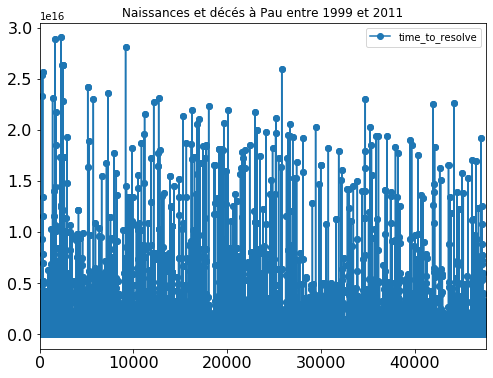

In [0]:
dfxy.plot(
    marker="o",
    title="Naissances et décés à Pau entre 1999 et 2011",
    figsize=(8, 6),
    fontsize=16,
)

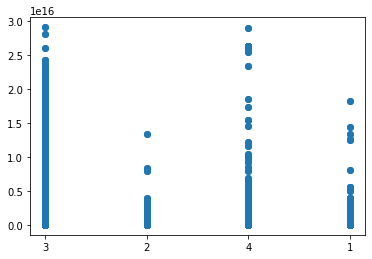

In [0]:
plt.plot_date(df_calcul_test["priority"].values, df_calcul_test["time_to_resolve"].values, xdate=False)

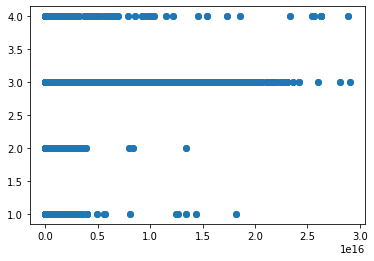

In [0]:
plt.plot_date(df_calcul_test["time_to_resolve"].values, df_calcul_test["priority"].values, xdate=False)